In [1]:
import warnings
# 仅在这个context里忽略警告
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    from coniii import *
import numpy as np
from tqdm.auto import tqdm
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import random
import Jangenerate_assembly #In the same dir
import Jangenerate_SpikeCount #In the same dir
from scipy.stats import poisson

import itertools
import time
import math

warnings.filterwarnings("ignore")


# Define Parameters
T = 3600 # time of simul“ation
dT = 0.5 # time step
params_assembly_num =5 # number of assemblies
params_point_into_neuron_distance = 0.5 

# Length of an active event as a number of timesteps
eventDur = np.random.randint(1, 10)
# Probability with which a unit is particularly active in a single timestep
eventProb = np.random.uniform(0.01, 0.05)
# Firing rate multiplier at active events
eventMult = np.random.uniform(6, 10)  # random number between 1 and 5
showPlot = False

In [2]:
def binaryOutput(original_list):
    # Create a new list to hold the tuples
    tuples_list = []

    # Generate all possible combinations of two elements for each sublist
    for sublist in original_list:
        combinations = itertools.combinations(sublist, 2)
        # Convert the combinations into tuples and add them to the list
        tuples_list.extend(tuple(sorted(combination)) for combination in combinations)

    # Remove duplicates by converting the list to a set then back to a list
    unique_tuples = list(set(tuples_list))
    
    return unique_tuples

In [12]:
N = [25,36,49,64,81]
params_assembly_density = [n // 6 for n in N] # size of neurons in each assembly

assemblies_list = []
spikeCount_list = []
binary_list = []

for i in tqdm(range (0, len(N))):
    fire_rate_background = np.random.uniform(1, 6, N[i])
    # Here's some preparatory code, we don't count its execution time
    assemblies = Jangenerate_assembly.generate_assembly_solve(N[i], params_assembly_num, params_assembly_density[i])
    # Output 0, 1 type spikes
    spikeCount = Jangenerate_SpikeCount.generateSpikeCountSolve(N[i], T, dT, assemblies, (1, 6), eventDur, eventProb, eventMult, showPlot)
    # Transform to -1, 1 distribution
    spikeCount[spikeCount == 0] = -1
    assemblies_list.append(assemblies)
    spikeCount_list.append(spikeCount)
    
    binary_list.append(binaryOutput(assemblies))

print(assemblies_list)
print()
print(binary_list)

  0%|          | 0/5 [00:00<?, ?it/s]

[[[0, 10, 6, 2], [15, 21, 12, 22], [7, 4, 14, 9], [10, 20, 21], [20, 11, 22, 23]], [[20, 32, 21, 33, 28], [12, 24, 13, 19, 14], [26, 27, 16, 34], [30, 25, 31, 26, 20], [28, 22, 34, 29, 23]], [[44, 31, 45, 24, 38, 32, 47], [7, 21, 36, 44, 23, 37, 31], [37, 31, 46, 39, 33, 47], [28, 42, 35, 29, 37], [0, 28, 7, 15, 8, 16]], [[33, 25, 34, 26, 19, 35, 21], [19, 20, 28, 5, 21, 37, 13, 7], [16, 32, 8, 24, 17, 9], [48, 56, 49, 57, 58, 51], [58, 51, 52, 44, 60, 53, 61, 54, 46]], [[72, 63, 73, 74, 65], [28, 38, 56, 29, 65, 39, 30, 48, 49], [75, 58, 67, 59, 77, 68, 78], [0, 18, 36, 9, 27, 19, 37, 10, 20, 29], [4, 13, 31, 5, 23, 14, 32, 6, 24, 15, 33]]]

[[(15, 21), (4, 9), (20, 23), (21, 22), (22, 23), (12, 22), (0, 2), (9, 14), (11, 23), (10, 21), (11, 20), (4, 14), (12, 15), (12, 21), (20, 22), (0, 10), (2, 10), (11, 22), (10, 20), (7, 9), (6, 10), (15, 22), (4, 7), (20, 21), (0, 6), (2, 6), (7, 14)], [(16, 26), (26, 30), (26, 27), (12, 13), (21, 28), (12, 19), (20, 32), (20, 26), (22, 23), (14

In [13]:
# Define a function to encapsulate the code you want to time
def code_to_time(spikeCount,threshold):
    solver = ClusterExpansion(spikeCount)
    multipliers, ent, clusters, deltaSdict, deltaJdict= solver.solve(threshold, full_output=True)
    return clusters

In [14]:
# 假设你已经有一个spikeCount_list和threshold
threshold = [0.2, 0.15, 0.1, 0.09, 0.08,0.07]

# # 创建一个字典，用于存储每个阈值的结果
results = {thresh: {'accuracy': []} for thresh in threshold}
resultss = {thresh: {'time': []} for thresh in threshold}

for thresh in tqdm(threshold):
    iter_ratio = []
    iter_times = []
    for i in range(len(spikeCount_list)):
        
        
        start_time = time.time()
        # 执行你的函数
        result = code_to_time(spikeCount_list[i], thresh)
        end_time = time.time()
        iter_times.append(end_time - start_time)

        set1 = set([tuple(sublist) for sublist in result[2]])
        set2 = set(binary_list[i])
        # 计算重复度的比率
        if len(set1) == 0:
            dup_ratio = 0
        else:
            dup_ratio = len(set1 & set2) / len(set2)

        iter_ratio.append(dup_ratio)
        print(set1, "--",set2, dup_ratio)
        print("--------------------")

        # 计算平均时间并添加到阈值的结果字典
    results[thresh]['accuracy'].extend(iter_ratio)
    resultss[thresh]['time'].extend(iter_times)

  0%|          | 0/6 [00:00<?, ?it/s]

set() -- {(15, 21), (4, 9), (20, 23), (21, 22), (22, 23), (12, 22), (0, 2), (9, 14), (11, 23), (10, 21), (11, 20), (12, 15), (20, 22), (4, 14), (12, 21), (0, 10), (2, 10), (11, 22), (10, 20), (7, 9), (6, 10), (15, 22), (4, 7), (20, 21), (0, 6), (2, 6), (7, 14)} 0
--------------------
{(22, 29)} -- {(16, 26), (26, 30), (26, 27), (12, 13), (21, 28), (12, 19), (20, 32), (20, 26), (22, 23), (14, 19), (23, 28), (22, 29), (23, 34), (28, 33), (19, 24), (13, 14), (27, 34), (32, 33), (25, 31), (20, 25), (16, 34), (20, 28), (12, 24), (21, 33), (20, 31), (22, 28), (29, 34), (14, 24), (22, 34), (28, 29), (28, 32), (13, 19), (25, 30), (16, 27), (12, 14), (20, 21), (26, 31), (26, 34), (20, 30), (20, 33), (21, 32), (23, 29), (28, 34), (30, 31), (25, 26), (13, 24)} 0.021739130434782608
--------------------
{(33, 39), (35, 42), (24, 45), (31, 44), (0, 8), (8, 15), (31, 47), (24, 32), (24, 38), (32, 45), (21, 36), (23, 36), (0, 16), (15, 16), (32, 38), (21, 23), (33, 46), (38, 45), (39, 46), (8, 16), (0

{(52, 58), (44, 54), (8, 9), (9, 17), (5, 28), (5, 37), (25, 34), (7, 28), (7, 37), (48, 56), (8, 32), (13, 28), (16, 24), (13, 37), (46, 52), (48, 49), (46, 61), (49, 57), (16, 17), (44, 51), (5, 7), (46, 54), (54, 58), (33, 35), (51, 52), (20, 28), (51, 61), (52, 60), (20, 37), (9, 16), (17, 32), (53, 61), (54, 60), (56, 57), (25, 33), (58, 60), (51, 54), (26, 34), (52, 53), (46, 58), (44, 58), (53, 54), (25, 26), (25, 35), (5, 13), (46, 51), (44, 60), (49, 56), (8, 24), (9, 32), (24, 32), (60, 61), (51, 58), (44, 53), (8, 17), (53, 58), (44, 46), (51, 60), (5, 20), (7, 20), (51, 53), (26, 33), (16, 32), (52, 61), (17, 24), (19, 21), (46, 60), (48, 57), (54, 61), (13, 20), (7, 13), (58, 61), (26, 35), (52, 54), (46, 53), (33, 34), (44, 52), (44, 61), (8, 16), (34, 35), (9, 24), (28, 37), (53, 60)} -- {(52, 58), (44, 54), (8, 9), (5, 19), (21, 37), (9, 17), (5, 28), (5, 37), (7, 19), (25, 34), (7, 28), (7, 37), (5, 21), (48, 56), (13, 19), (8, 32), (13, 28), (16, 24), (7, 21), (13, 37

{(72, 73), (13, 33), (24, 33), (67, 68), (67, 77), (20, 29), (14, 31), (28, 30), (68, 75), (10, 27), (15, 23), (30, 39), (10, 36), (18, 19), (15, 32), (73, 74), (30, 48), (18, 37), (59, 75), (14, 15), (9, 10), (14, 24), (4, 23), (48, 56), (9, 19), (14, 33), (4, 32), (48, 65), (68, 77), (10, 20), (27, 36), (6, 13), (10, 29), (0, 37), (59, 68), (38, 39), (29, 36), (5, 14), (31, 33), (48, 49), (38, 48), (0, 9), (5, 23), (5, 32), (27, 29), (77, 78), (29, 38), (23, 31), (75, 78), (29, 56), (13, 14), (19, 27), (13, 23), (28, 39), (19, 36), (28, 48), (58, 67), (23, 24), (20, 37), (23, 33), (29, 49), (19, 20), (19, 29), (72, 74), (30, 38), (9, 37), (63, 72), (30, 56), (6, 31), (4, 13), (14, 23), (58, 78), (59, 77), (14, 32), (4, 31), (10, 19), (0, 18), (0, 27), (10, 37), (0, 36), (63, 74), (6, 15), (30, 49), (6, 24), (4, 6), (6, 33), (5, 13), (4, 15), (31, 32), (4, 24), (38, 56), (49, 56), (4, 33), (39, 48), (27, 37), (0, 20), (0, 29), (13, 32), (24, 32), (5, 6), (29, 37), (38, 49), (75, 77), 

{(72, 73), (13, 33), (24, 33), (67, 68), (67, 77), (20, 29), (14, 31), (28, 30), (68, 75), (10, 27), (15, 23), (30, 39), (10, 36), (18, 19), (15, 32), (73, 74), (30, 48), (18, 37), (59, 75), (14, 15), (9, 10), (14, 24), (4, 23), (48, 56), (9, 19), (14, 33), (65, 72), (4, 32), (48, 65), (68, 77), (10, 20), (27, 36), (6, 13), (10, 29), (0, 37), (59, 68), (38, 39), (29, 36), (5, 14), (31, 33), (48, 49), (38, 48), (0, 9), (5, 23), (5, 32), (27, 29), (77, 78), (29, 38), (23, 31), (75, 78), (29, 56), (13, 14), (19, 27), (13, 23), (28, 39), (19, 36), (28, 48), (58, 67), (23, 24), (20, 37), (23, 33), (29, 49), (19, 20), (19, 29), (72, 74), (30, 38), (9, 37), (63, 72), (30, 56), (6, 31), (4, 13), (14, 23), (58, 78), (59, 77), (14, 32), (4, 31), (10, 19), (65, 74), (0, 18), (0, 27), (10, 37), (0, 36), (63, 74), (6, 15), (30, 49), (6, 24), (4, 6), (6, 33), (5, 13), (4, 15), (31, 32), (4, 24), (38, 56), (49, 56), (4, 33), (39, 48), (27, 37), (0, 20), (0, 29), (13, 32), (24, 32), (5, 6), (29, 37), 

{(72, 73), (13, 33), (24, 33), (67, 68), (67, 77), (20, 29), (14, 31), (28, 30), (68, 75), (10, 27), (15, 23), (30, 39), (10, 36), (18, 19), (15, 32), (73, 74), (30, 48), (18, 37), (59, 75), (14, 15), (9, 10), (14, 24), (4, 23), (48, 56), (9, 19), (14, 33), (65, 72), (4, 32), (48, 65), (68, 77), (10, 20), (27, 36), (6, 13), (10, 29), (0, 37), (59, 68), (38, 39), (29, 36), (5, 14), (31, 33), (48, 49), (38, 48), (0, 9), (5, 23), (5, 32), (27, 29), (77, 78), (29, 38), (23, 31), (75, 78), (29, 56), (13, 14), (19, 27), (13, 23), (28, 39), (19, 36), (28, 48), (58, 67), (23, 24), (20, 37), (23, 33), (29, 49), (19, 20), (19, 29), (72, 74), (30, 38), (9, 37), (63, 72), (30, 56), (6, 31), (4, 13), (14, 23), (58, 78), (59, 77), (14, 32), (4, 31), (10, 19), (65, 74), (0, 18), (0, 27), (63, 65), (10, 37), (0, 36), (63, 74), (6, 15), (30, 49), (6, 24), (4, 6), (6, 33), (5, 13), (4, 15), (31, 32), (4, 24), (38, 56), (49, 56), (4, 33), (39, 48), (27, 37), (0, 20), (0, 29), (13, 32), (24, 32), (5, 6), 

{(72, 73), (13, 33), (24, 33), (67, 68), (67, 77), (20, 29), (14, 31), (28, 30), (68, 75), (10, 27), (15, 23), (30, 39), (10, 36), (18, 19), (15, 32), (73, 74), (30, 48), (18, 37), (59, 75), (14, 15), (9, 10), (14, 24), (4, 23), (48, 56), (9, 19), (14, 33), (65, 72), (4, 32), (48, 65), (68, 77), (10, 20), (27, 36), (6, 13), (10, 29), (0, 37), (59, 68), (38, 39), (29, 36), (5, 14), (31, 33), (48, 49), (38, 48), (0, 9), (5, 23), (5, 32), (27, 29), (77, 78), (29, 38), (23, 31), (75, 78), (29, 56), (13, 14), (19, 27), (13, 23), (28, 39), (19, 36), (28, 48), (58, 67), (23, 24), (20, 37), (23, 33), (29, 49), (19, 20), (19, 29), (72, 74), (30, 38), (9, 37), (63, 72), (30, 56), (6, 31), (4, 13), (14, 23), (58, 78), (59, 77), (14, 32), (4, 31), (10, 19), (65, 74), (0, 18), (0, 27), (63, 65), (10, 37), (0, 36), (63, 74), (6, 15), (30, 49), (6, 24), (4, 6), (6, 33), (5, 13), (4, 15), (31, 32), (4, 24), (38, 56), (49, 56), (4, 33), (39, 48), (27, 37), (0, 20), (0, 29), (29, 65), (13, 32), (24, 32)

In [15]:
results

{0.2: {'accuracy': [0,
   0.021739130434782608,
   0.26582278481012656,
   0.5398230088495575,
   0.7964071856287425]},
 0.15: {'accuracy': [0.18518518518518517,
   0.41304347826086957,
   0.3291139240506329,
   0.7345132743362832,
   0.9281437125748503]},
 0.1: {'accuracy': [0.6666666666666666,
   0.8260869565217391,
   0.7721518987341772,
   0.9823008849557522,
   0.9700598802395209]},
 0.09: {'accuracy': [0.7777777777777778,
   0.8260869565217391,
   0.8227848101265823,
   1.0,
   0.9880239520958084]},
 0.08: {'accuracy': [0.8148148148148148,
   0.9130434782608695,
   0.8481012658227848,
   1.0,
   0.9940119760479041]},
 0.07: {'accuracy': [0.8148148148148148,
   0.9565217391304348,
   0.9240506329113924,
   1.0,
   1.0]}}

In [16]:
resultss

{0.2: {'time': [2.5917630195617676,
   3.9655044078826904,
   6.43807315826416,
   15.846058130264282,
   294.84125232696533]},
 0.15: {'time': [2.6923179626464844,
   4.64626669883728,
   6.5897040367126465,
   30.659013271331787,
   1155.5236721038818]},
 0.1: {'time': [3.0781240463256836,
   6.205128192901611,
   11.705969333648682,
   122.96571135520935,
   1418.059282541275]},
 0.09: {'time': [3.3648505210876465,
   6.585572719573975,
   13.412160396575928,
   130.7677137851715,
   1371.3666729927063]},
 0.08: {'time': [3.1401150226593018,
   6.537277936935425,
   16.121196031570435,
   122.74457335472107,
   1353.496374130249]},
 0.07: {'time': [3.0266530513763428,
   6.814855575561523,
   19.48730993270874,
   126.77935791015625,
   1333.5747275352478]}}

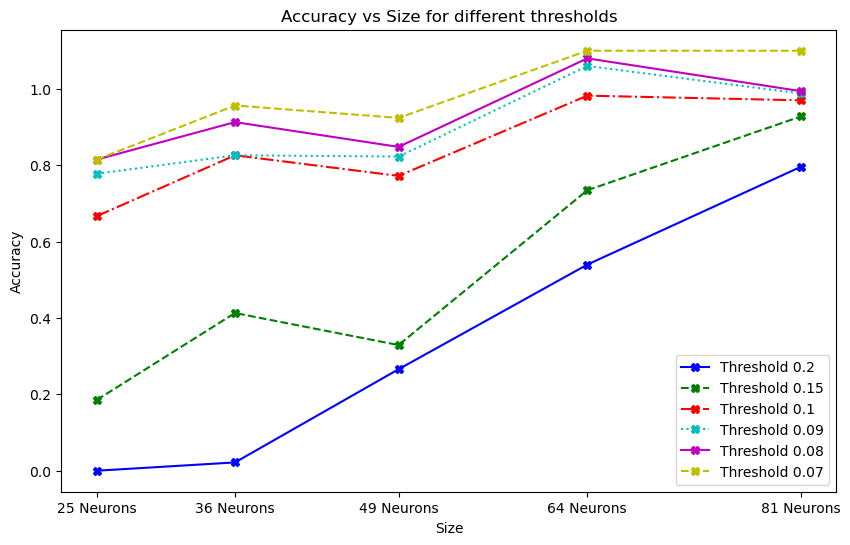

In [36]:
# Different line styles and colors
plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']
colors = ['b', 'g', 'r', 'c', 'm', 'y']

for index, (threshold, data) in enumerate(results.items()):
    plt.plot(N, [acc + 0.02 * index if acc == 1.0 else acc for acc in data['accuracy']], line_styles[index % len(line_styles)], color=colors[index % len(colors)], label=f'Threshold {threshold}', marker = "X")

plt.xlabel('Size')
plt.ylabel('Accuracy')
# 创建新的标签列表
labels = [f'{n} Neurons' for n in N]
plt.xticks(N, labels)

plt.title('Accuracy vs Size for different thresholds')
plt.legend(loc='lower right')

plt.show()

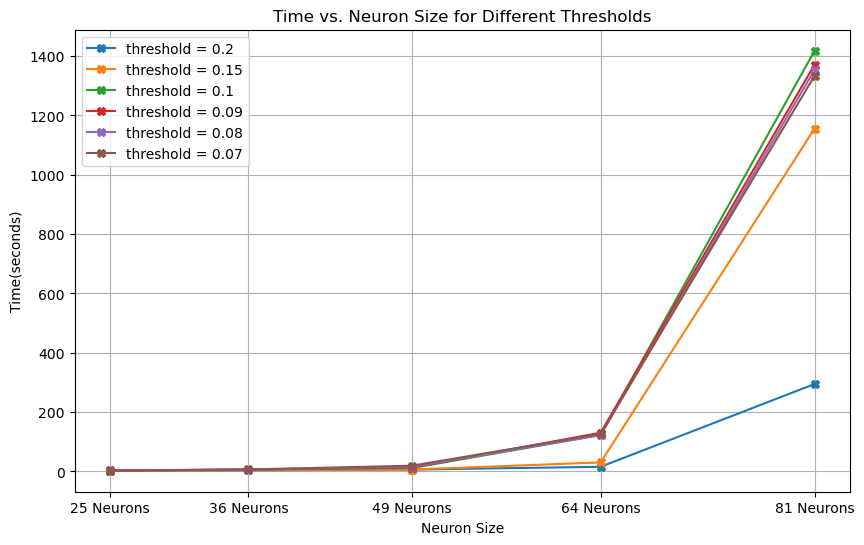

In [35]:
plt.figure(figsize=(10, 6))
for threshold, time_data in resultss.items():
    plt.plot(N, time_data['time'], label=f'threshold = {threshold}', marker = 'X')

plt.xlabel('Neuron Size')
plt.ylabel('Time(seconds)')
plt.title('Time vs. Neuron Size for Different Thresholds')
# 创建新的标签列表
labels = [f'{n} Neurons' for n in N]
plt.xticks(N, labels)

plt.legend()
plt.grid(True)
plt.show()